In [1]:
import tensorflow as tf
import os

from tensorflow.keras.layers import Concatenate
import IPython
import IPython.display
import matplotlib as mpl
import datetime
import pandas as pd
import numpy as np
import talib
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import mplfinance as mpf
import joblib

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-04-29 14:01:11.965975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('training_data.csv')
columns_to_delete = ['timestamp']
for col in columns_to_delete:
    del df[col]

In [3]:
# Identify candlestick patterns using TA-Lib
patterns = ['CDL3INSIDE', 'CDL3LINESTRIKE', 'CDLHANGINGMAN', 'CDL3WHITESOLDIERS', 
            'CDL3BLACKCROWS', 'CDLHARAMI', 'CDLEVENINGSTAR']

# Example list of patterns
for pattern in patterns:
    df[pattern] = getattr(talib, pattern)(df['open'], df['high'], df['low'], df['close'])
    
df['Patterns'] = 0  # Default: No pattern
for pattern in patterns:
    df.loc[df[pattern] > 0, 'Patterns'] = 1  # Bullish pattern
    df.loc[df[pattern] < 0, 'Patterns'] = -1  # Bearish pattern

# One-hot encode each pattern
for pattern in patterns:
    df[pattern] = (df[pattern] != 0).astype(int)

In [4]:
df 

,open,high,low,close,volume,CDL3INSIDE,CDL3LINESTRIKE,CDLHANGINGMAN,CDL3WHITESOLDIERS,CDL3BLACKCROWS,CDLHARAMI,CDLEVENINGSTAR,Patterns
0,295.0500,295.7500,295.0500,295.7300,21691,0,0,0,0,0,0,0,0
1,295.7500,296.0500,295.7500,296.0000,13077,0,0,0,0,0,0,0,0
2,295.7500,295.8500,295.3000,295.5100,11742,0,0,0,0,0,0,0,0
3,295.5000,296.1800,295.1300,296.1000,110251,0,0,0,0,0,0,0,0
4,295.8898,296.7500,295.4350,296.6803,178656,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16409,185.9800,186.0300,184.3500,184.3600,9880076,0,0,0,0,0,0,0,0
16410,184.4400,187.8294,175.7564,184.9000,21775326,0,0,0,0,0,1,0,1
16411,184.8700,185.2900,184.4000,185.1000,258672,0,0,0,0,0,0,0,0
16412,185.1200,185.4500,184.4000,185.3800,38555,0,0,1,0,0,0,0,-1


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,16414.0,1.822384e+02,7.374589e+01,104.08,139.625000,1.584000e+02,1.836475e+02,5.138900e+02
high,16414.0,1.828844e+02,7.400484e+01,105.20,140.202500,1.590100e+02,1.844820e+02,5.159800e+02
low,16414.0,1.815250e+02,7.349499e+01,103.10,139.013625,1.577250e+02,1.823600e+02,5.082000e+02
close,16414.0,1.822502e+02,7.377952e+01,104.05,139.632500,1.584142e+02,1.836988e+02,5.138900e+02
volume,16414.0,4.304374e+06,5.688038e+06,300.00,47537.500000,1.557352e+06,7.270841e+06,1.059038e+08
CDL3INSIDE,16414.0,7.249909e-03,8.483977e-02,0.00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
CDL3LINESTRIKE,16414.0,3.594493e-03,5.984806e-02,0.00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
CDLHANGINGMAN,16414.0,5.623248e-02,2.303771e-01,0.00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
CDL3WHITESOLDIERS,16414.0,1.827708e-03,4.271392e-02,0.00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
CDL3BLACKCROWS,16414.0,6.092360e-04,2.467594e-02,0.00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00


In [6]:
# Extract the columns you want to scale
columns_to_scale = ['open', 'high', 'low', 'close', 'volume']
data_to_scale = df[columns_to_scale]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(data_to_scale)

# Create a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Replace the original columns with the scaled columns in the original DataFrame
df[columns_to_scale] = scaled_df

# Now df contains the Min-Max scaled values for the selected columns

In [7]:
# Extract the columns you want to scale
columns_to_scale = ['open', 'high', 'low', 'close', 'volume']
data_to_scale = df[columns_to_scale]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(data_to_scale)

# Create a DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Replace the original columns with the scaled columns in the original DataFrame
df[columns_to_scale] = scaled_df

# Now df contains the Min-Max scaled values for the selected columns

In [8]:
df

,open,high,low,close,volume,CDL3INSIDE,CDL3LINESTRIKE,CDLHANGINGMAN,CDL3WHITESOLDIERS,CDL3BLACKCROWS,CDLHARAMI,CDLEVENINGSTAR,Patterns
0,0.465996,0.463874,0.473834,0.467695,0.000202,0,0,0,0,0,0,0,0
1,0.467705,0.464604,0.475562,0.468354,0.000121,0,0,0,0,0,0,0,0
2,0.467705,0.464117,0.474451,0.467158,0.000108,0,0,0,0,0,0,0,0
3,0.467095,0.464920,0.474031,0.468598,0.001038,0,0,0,0,0,0,0,0
4,0.468046,0.466308,0.474784,0.470013,0.001684,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16409,0.199849,0.196772,0.200568,0.195955,0.093290,0,0,0,0,0,0,0,0
16410,0.196091,0.201152,0.179354,0.197272,0.205612,0,0,0,0,0,1,0,1
16411,0.197140,0.194971,0.200691,0.197760,0.002440,0,0,0,0,0,0,0,0
16412,0.197750,0.195360,0.200691,0.198443,0.000361,0,0,1,0,0,0,0,-1


In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [15]:
def preprocess_stock_data(ticker_symbol, patterns, columns_to_scale, scaler):
    # Download historical stock data
    # Get current date
    current_date = pd.Timestamp.today()
    
    # Set end date as the next day's date
    end_date = (current_date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
    
    start_date = (pd.Timestamp.today() - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
    ticker = yf.Ticker(ticker_symbol)
    ticker_historical = ticker.history(start=start_date, end=end_date, interval="1h")
    
    # Save historical data to CSV
    ticker_historical.to_csv('{}_historical.csv'.format(ticker_symbol))
    
    # Read data from CSV
    raw_df = pd.read_csv('{}_historical.csv'.format(ticker_symbol))[::-1]
    
    # Delete the first 10 rows
    raw_df = raw_df.iloc[-12:]

    # If you want to reset the index after deleting the rows
    raw_df.reset_index(drop=True, inplace=True)
    
    # Clean data
    delete_columns = ['Dividends', 'Stock Splits', 'Datetime']
    raw_df.drop(columns=delete_columns, inplace=True)
    
    # Rename columns
    raw_df = raw_df.rename(columns={'Open': 'open', 'High': 'high','Low': 'low','Close': 'close','Volume': 'volume'}, inplace=False)
    
    # Calculate candlestick patterns
    for pattern in patterns:
        raw_df[pattern] = getattr(talib, pattern)(raw_df['open'], raw_df['high'], raw_df['low'], raw_df['close'])
    
    # Create a combined indicator column
    raw_df['Pattern'] = 0  # Default: No pattern
    for pattern in patterns:
        raw_df.loc[raw_df[pattern] > 0, 'Pattern'] = 1  # Bullish pattern
        raw_df.loc[raw_df[pattern] < 0, 'Pattern'] = -1  # Bearish pattern
    
    # One-hot encode each pattern
    for pattern in patterns:
        raw_df[pattern] = (raw_df[pattern] != 0).astype(int)
    
    # Scale selected columns using the provided scaler
    scaled_data = scaler.transform(raw_df[columns_to_scale])
    scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
    raw_df[columns_to_scale] = scaled_df
    
    return raw_df

In [35]:
preprocessed_data = preprocess_stock_data('TSLA', patterns, columns_to_scale, scaler)
preprocessed_data

,open,high,low,close,volume,CDL3INSIDE,CDL3LINESTRIKE,CDLHANGINGMAN,CDL3WHITESOLDIERS,CDL3BLACKCROWS,CDLHARAMI,CDLEVENINGSTAR,Pattern
0,166.733994,167.057495,165.900604,165.960007,7842816.0,0,0,0,0,0,0,0,0
1,166.255005,167.690002,166.000000,166.730194,10328349.0,0,0,0,0,0,0,0,0
2,165.669998,166.649994,165.112900,166.259995,11561980.0,0,0,0,0,0,0,0,0
3,165.580002,165.870697,163.899994,165.669998,18110912.0,0,0,0,0,0,0,0,0
4,164.688995,167.190002,163.429993,165.570099,45944518.0,0,0,0,0,0,0,0,0
5,173.949997,175.289993,173.190094,175.119995,8080117.0,0,0,0,0,0,0,0,0
6,172.919998,174.086807,172.590103,173.955002,7463119.0,0,0,0,0,0,0,0,0
7,171.860001,173.104996,171.750000,172.940002,5705376.0,0,0,0,0,0,0,0,0
8,172.288193,173.277100,171.740005,171.889999,7020081.0,0,0,0,0,0,0,0,0
9,172.089996,172.429993,170.889999,172.279999,8095873.0,0,0,0,0,0,0,0,0


In [27]:
POUT_STEPS = 6
predict_multi_window = WindowGenerator(input_width = 6, label_width = POUT_STEPS, shift=POUT_STEPS)

In [28]:
multi_data_windows = predict_multi_window.make_dataset(preprocessed_data)
multi_data_windows

<_MapDataset element_spec=(TensorSpec(shape=(None, 6, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6, 13), dtype=tf.float32, name=None))>

In [29]:
# Load the model
LSTM_Model = tf.keras.models.load_model('Multi_LSTM')

# Use the loaded model for prediction
lstm_predictions = LSTM_Model.predict(multi_data_windows)

1/1 [==============================] - 0s 438ms/step


In [30]:
lstm_predictions

array([[[0.429693  , 0.446768  , 0.42948654, 0.44234055, 1.1942644 ],
        [0.2050377 , 0.2021579 , 0.22667909, 0.20875156, 0.41842434],
        [0.19665064, 0.18533151, 0.21181211, 0.19530532, 0.27904627],
        [0.28767622, 0.28932938, 0.2806428 , 0.28399453, 0.28127944],
        [0.31222326, 0.33822522, 0.29071003, 0.31559226, 0.9398647 ],
        [0.3191388 , 0.3468653 , 0.2873513 , 0.31577897, 0.9249515 ]]],
      dtype=float32)

In [31]:
def toCandle(prediction_data, scaler, columns_to_scale):
    # Inverse transform the scaled predictions
    unscaled_predictions = scaler.inverse_transform(prediction_data)

    # Create a DataFrame from the unscaled predictions
    unscaled_df = pd.DataFrame(unscaled_predictions, columns=columns_to_scale)
    
    #Create output csv
    unscaled_df.to_csv('output.csv', index=False)
    
    # Convert the index to datetime if needed
    unscaled_df.index = pd.to_datetime(unscaled_df.index)

    # Plot the candlestick chart
    mpf.plot(unscaled_df, type='candle')

In [32]:
def plot_comparison(df1, df2):
    # Specify different colors for each feature
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Plot line graphs for each feature in the first DataFrame
    for i, col in enumerate(df1.columns):
        plt.plot(df1.index, df1[col], color=colors[i], label=None)
    
    # Plot line graphs for each feature in the second DataFrame
    for i, col in enumerate(df2.columns):
        plt.plot(df2.index, df2[col], color=colors[i], linestyle='dashed', label=None )

    # Add legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Comparison of Features between Actual and Predicted')

    # Show the plot
    plt.show()

In [33]:
#toCandle(<model_predictions>[0], scaler, columns_to_scale)

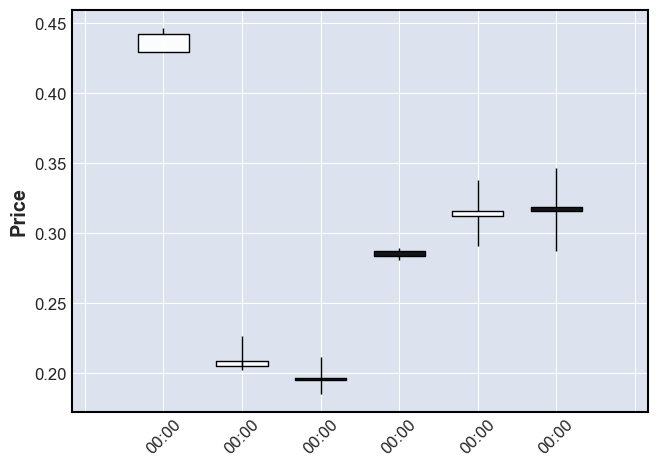

In [34]:
toCandle(lstm_predictions[0], scaler, columns_to_scale)

In [25]:
# prediction_df = pd.DataFrame(<model_prediction>[0], columns=['open', 'high', 'low', 'close','volume'])
# plot_comparison(actual_df,prediction_df)